In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import math
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table
import mpl_style

H0 = 72.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [2]:
hdulist = fits.open('../JHU_mstell_ssfr_Yang_gzoo.fits')
tbdata = hdulist[1].data
color = tbdata['col10'] #^{0.1}(g-r), K-E corrected to z=0.1, petro
M_r = tbdata['col9'] #^{0.1}(M_r) - 5\log h, K-E corrected to z=0.1, petro
centsat = tbdata['col4_2'] #if BRIGHTEST galaxy in group, is 1, otherwise 2
pfeatures = tbdata['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
psmooth = tbdata['t01_smooth_or_features_a01_smooth_weighted_fraction']
#absmag = tbdata['ABSMAG']
#absmag_r = absmag[:,4]
ssfr = tbdata['AVG_SSFR']
z = tbdata['Z'] #Schlegel redshift from mpa-jhu
z_warn = tbdata['Z_WARNING'] #if non-zero, don't sue Schlegel redshift
#mass = tbdata['MASS'] #stellar mass from K correction fit, in h^-2 Msun units (from nsatlas)
mass = tbdata['AVG_MSTELL']
group_num = tbdata['col3_2']
galaxy_num = tbdata['col1_2']
hdulist.close()

hdulist2 = fits.open('../petroC_group.fits')
tbdata2 = hdulist2[1].data
petroC_group_num = tbdata2['col1'] #group number
petroC_halo_mass = tbdata2['col7'] #Luminosity weighted halo mass estimate, units: log M_halo/ (M_{\odot}/h)
hdulist2.close()

In [3]:
table = Table(tbdata)
#table

In [4]:
#Magnitude limit calculation
z_lim = 0.06
d = cosmo.luminosity_distance(z_lim).to(u.pc)
m = 17
M_limit = m - 5*math.log(d.value,10) + 5 
adj_M_limit = M_limit - 5*math.log(h,10)

Sorting into color/sf groups, and galaxy groups

In [ ]:
halo_mass = []

redpas_ind = []
redpas_pfeatures = []
redpas_psmooth = []
redpas_color = []
redpas_sfr = []
redpas_mr = []
redpas_mass = []

bluact_ind = []
bluact_pfeatures = []
bluact_psmooth = []
bluact_color = []
bluact_sfr = []
bluact_mr = []
bluact_mass = []

redact_ind = []
redact_pfeatures = []
redact_psmooth = []
redact_color = []
redact_sfr = []
redact_mr = []
redact_mass = []

group_list = [[67926]]
#a = True

for i in np.arange(pfeatures.size):
    group_ind = np.where(petroC_group_num == group_num[i])
    halo_mass.append((petroC_halo_mass[group_ind[0]], centsat[i]))
    
    if z[i] > 0.01 and z[i] < 0.06: #and z_warn[i] == 0:# and absmag_r[i] < M_limit:
    #if a == True: #just doing this to get rid of all restrictions without having to unindent the rest of it
        groups = np.array([item[0] for item in group_list])
        ind = np.where(groups == group_num[i])
        if ind[0].size == 0: #if the group isn't in the array yet
            group_list.append([group_num[i]])
            group_list[-1].append(galaxy_num[i])
        else:
            group_list[np.squeeze(ind[0])].append(galaxy_num[i])
        color_line = 0.7 - 0.032*(M_r[i] + 16.5)
        active_line = -10 + 0.094*(M_r[i] + 15)
        logSSFR = ssfr[i]
        
        if color[i] > color_line: #red galaxies
            if logSSFR <= active_line: #passive galaxies - redpas type
                redpas_ind.append((i, centsat[i]))
                redpas_pfeatures.append((pfeatures[i], centsat[i]))
                redpas_psmooth.append((psmooth[i], centsat[i]))
                redpas_color.append((color[i], centsat[i]))
                redpas_sfr.append((logSSFR, centsat[i]))
                redpas_mr.append((M_r[i], centsat[i]))
                redpas_mass.append((mass[i], centsat[i]))
            else: #red and active - redact type
                redact_ind.append((i, centsat[i]))
                redact_pfeatures.append((pfeatures[i], centsat[i]))
                redact_psmooth.append((psmooth[i], centsat[i]))
                redact_color.append((color[i], centsat[i]))
                redact_sfr.append((logSSFR,centsat[i]))
                redact_mr.append((M_r[i],centsat[i]))
                redact_mass.append((mass[i], centsat[i]))
        elif logSSFR >= active_line and color[i] < color_line: #blue and active - bluact type
            bluact_ind.append((i, centsat[i]))
            bluact_pfeatures.append((pfeatures[i],centsat[i]))
            bluact_psmooth.append((psmooth[i],centsat[i]))
            bluact_color.append((color[i],centsat[i]))
            bluact_sfr.append((logSSFR,centsat[i]))
            bluact_mr.append((M_r[i],centsat[i]))
            bluact_mass.append((mass[i],centsat[i]))

in the above cell, we create the list 'group_list' which has the group number of each galaxy group followed by the galaxy numbers of each galaxy in that group. In this cell, we use this list to calculate the average pspiral and ssfr of the satellites of each central

In [57]:
cent_pspiral = []
sat_pspiral_edit = [] #array of pspiral only for groups with centrals
sat_pspiral_all = [] #pspiral of satellites for all groups

cent_ssfr = []
sat_ssfr = []

frac_sat_spiral = []
frac_sat_sfing = []

for gr in group_list:
    group_gals = gr[1:] #gets the galaxies for each group, excludes group number
    if len(group_gals) > 1: #remove single galaxy groups
        has_central = False
        sat_list = []
        sat_ssfr_group = []
        sat_spiral = 0
        sat_sfing = 0
        sat_num = 0
        
        for gal in group_gals: #now loop through these galaxies
            ind = np.where(galaxy_num == gal) #index to use in other arrays for this galaxy
            if centsat[ind[0]] == 1:
                cent_ssfr.append(ssfr[ind[0][0]])
                cent_pspiral.append(pfeatures[ind[0][0]])
                has_central = True
            else:
                sat_num += 1
                sat_list.append(pfeatures[ind[0][0]])
                sat_ssfr_group.append(ssfr[ind[0][0]])
                if pfeatures[ind[0][0]] > 0.5:
                    sat_spiral += 1
                if ssfr[ind[0][0]] > (-10 + 0.094*(M_r[ind[0][0]] + 15)):
                    sat_sfing += 1
        sat_pspiral_all.append(np.mean(np.array(sat_list)))
        if len(sat_list) < 1:
            print group_gals
        if has_central == True:
            sat_pspiral_edit.append(np.mean(np.array(sat_list)))
            sat_ssfr.append(np.mean(np.array(sat_ssfr_group)))
            frac_sat_spiral.append(sat_spiral/sat_num)
            frac_sat_sfing.append(sat_sfing/sat_num)

(232014, 232014)


/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide
/homes/ashill/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


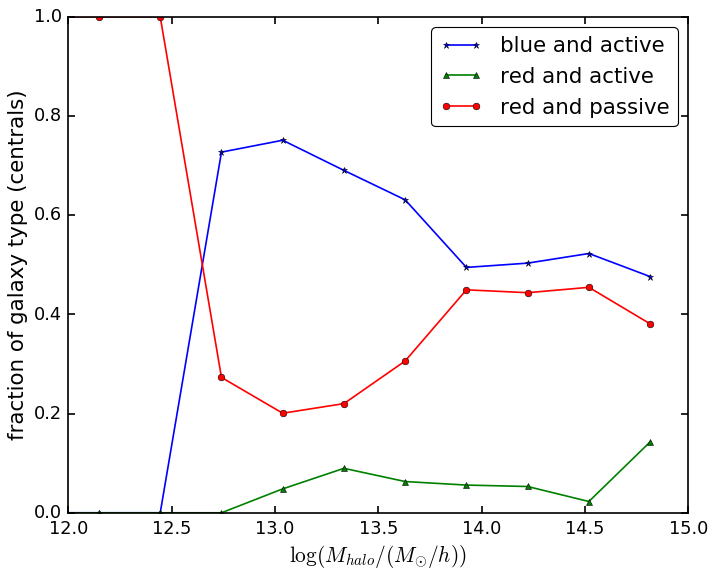

In [107]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

bluact_ind_cent = [x[0] for x in bluact_ind if x[1]==1]
redact_ind_cent = [x[0] for x in redact_ind if x[1]==1]
redpas_ind_cent = [x[0] for x in redpas_ind if x[1]==1]

halo_mass = np.array(halo_mass)
print(len(halo_mass), len(centsat))
bluact_halo_mass_cent = halo_mass[bluact_ind_cent]
redact_halo_mass_cent = halo_mass[redact_ind_cent]
redpas_halo_mass_cent = halo_mass[redpas_ind_cent]

bluact_hist,a = np.histogram(bluact_halo_mass_cent, bins=50)
redact_hist,b = np.histogram(redact_halo_mass_cent, bins=50)
redpas_hist,bin_edges = np.histogram(redpas_halo_mass_cent, bins=50)
all_hist = bluact_hist + redact_hist + redpas_hist

bluact_norm_hist = bluact_hist/all_hist
redact_norm_hist = redact_hist/all_hist
redpas_norm_hist = redpas_hist/all_hist

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, bluact_norm_hist, c='b', marker='*', label='blue and active')
plt.plot(bin_edges_adj, redact_norm_hist, c='g', marker='^', label='red and active')
plt.plot(bin_edges_adj, redpas_norm_hist, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of galaxy type (centrals)')
plt.xlabel(r'$\log (M_{halo}/ (M_{\odot}/h))$')
plt.xlim(12, 15)
#plt.ylim(0,1)

plt.show()

In [ ]:
fig = plt.figure(figsize=(10,8))
plt.style.use(mpl_style.style1)

bluact_ind_sat = [x[0] for x in bluact_ind if x[1]==2]
redact_ind_sat = [x[0] for x in redact_ind if x[1]==2]
redpas_ind_sat = [x[0] for x in redpas_ind if x[1]==2]

halo_mass = np.array(halo_mass)
print(len(halo_mass), len(centsat))
bluact_halo_mass_sat = halo_mass[bluact_ind_sat]
redact_halo_mass_sat = halo_mass[redact_ind_sat]
redpas_halo_mass_sat = halo_mass[redpas_ind_sat]

bluact_hist,a = np.histogram(bluact_halo_mass_sat, bins=50)
redact_hist,b = np.histogram(redact_halo_mass_sat, bins=50)
redpas_hist,bin_edges = np.histogram(redpas_halo_mass_sat, bins=50)
all_hist = bluact_hist + redact_hist + redpas_hist

bluact_norm_hist = bluact_hist/all_hist
redact_norm_hist = redact_hist/all_hist
redpas_norm_hist = redpas_hist/all_hist

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, bluact_norm_hist, c='b', marker='*', label='blue and active')
plt.plot(bin_edges_adj, redact_norm_hist, c='g', marker='^', label='red and active')
plt.plot(bin_edges_adj, redpas_norm_hist, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of galaxy type (satellites)')
plt.xlabel(r'$\log (M_{halo}/ (M_{\odot}/h))$')
plt.xlim(12, 15)
#plt.ylim(0,1)

plt.show()

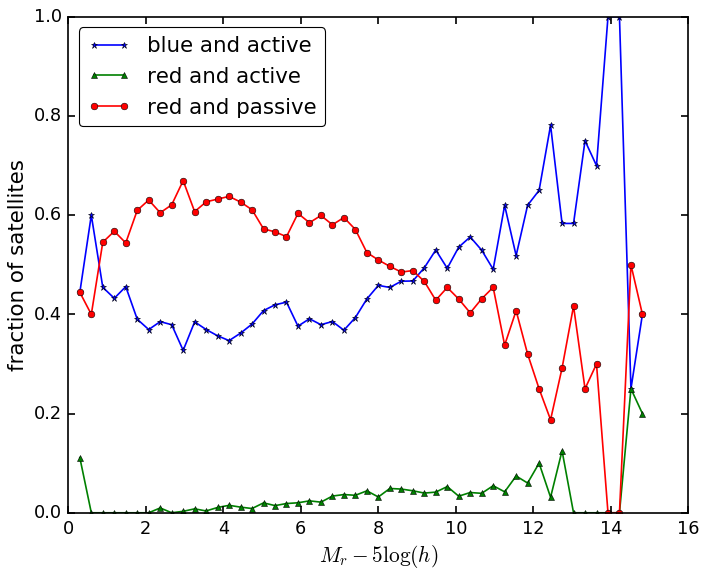

In [106]:
fig = plt.figure(figsize=(10,8))
bluact_mr_sat = [x[0] for x in bluact_mr if x[1]==2]
redact_mr_sat = [x[0] for x in redact_mr if x[1]==2]
redpas_mr_sat = [x[0] for x in redpas_mr if x[1]==2]
all_mr_sat = np.concatenate((bluact_mr_sat,redact_mr_sat,redpas_mr_sat))
plt.style.use(mpl_style.style1)

bluact_mr_hist,a = np.histogram(bluact_mr_sat, bins=50)
redact_mr_hist,b = np.histogram(redact_mr_sat, bins=50)
redpas_mr_hist,c = np.histogram(redpas_mr_sat, bins=50)
all_mr_hist = bluact_mr_hist + redact_mr_hist + redpas_mr_hist

bluact_mr_hist = bluact_mr_hist/all_mr_hist
redact_mr_hist = redact_mr_hist/all_mr_hist
redpas_mr_hist = redpas_mr_hist/all_mr_hist

#bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, bluact_mr_hist, c='b', marker='*', label='blue and active')
plt.plot(bin_edges_adj, redact_mr_hist, c='g', marker='^', label='red and active')
plt.plot(bin_edges_adj, redpas_mr_hist, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of satellites')
plt.xlabel(r'$M_r - 5\log(h)$')
#plt.xlim(-15,-22)
plt.ylim(0,1)

plt.show()

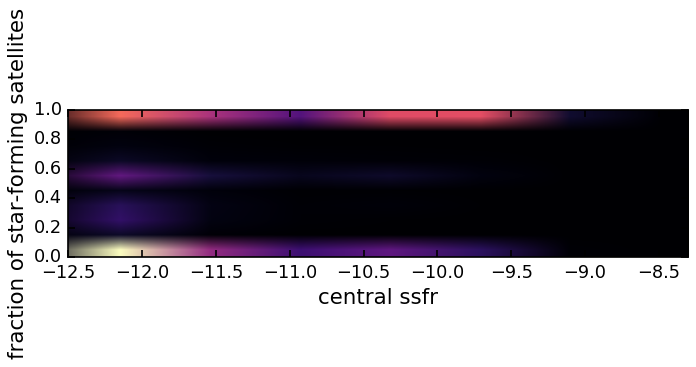

In [69]:
plt.style.use(mpl_style.style1)
plt.figure(figsize=(10,20))
hist, xedges, yedges = np.histogram2d(frac_sat_sfing,cent_ssfr, 10)
plt.imshow(hist, extent=[np.min(cent_ssfr), np.max(cent_ssfr),np.min(frac_sat_sfing), np.max(frac_sat_sfing)])
#plt.scatter(cent_ssfr, frac_sat_sfing)
plt.xlabel('central ssfr')
plt.ylabel('fraction of star-forming satellites')
plt.ylim(0,1)
plt.xlim(-12.5,-8.3)
plt.show()

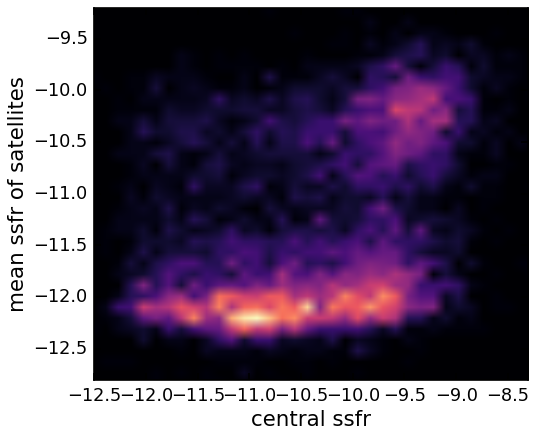

In [56]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(cent_ssfr, sat_ssfr, 50)

plt.imshow(hist, extent=[np.min(cent_ssfr), np.max(cent_ssfr),np.min(sat_ssfr), np.max(sat_ssfr)])
#plt.scatter(cent_ssfr, sat_ssfr)
plt.xlabel('central ssfr')
plt.ylabel('mean ssfr of satellites')
plt.ylim(-12.8,-9.2)
plt.xlim(-12.5,-8.3)
plt.show()

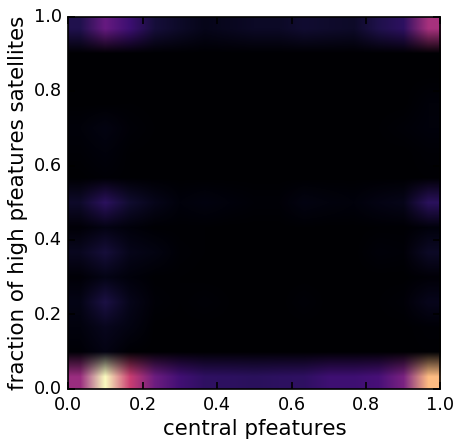

In [85]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(frac_sat_spiral, cent_pspiral, 15)

plt.imshow(hist, extent=[np.min(cent_pspiral), np.max(cent_pspiral),np.min(frac_sat_spiral), np.max(frac_sat_spiral)])

#plt.scatter(cent_pspiral, frac_sat_spiral)
plt.xlabel('central pfeatures')
plt.ylabel('fraction of high pfeatures satellites')
plt.show()

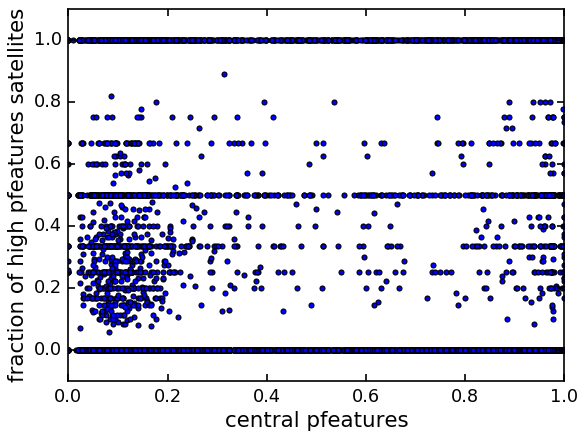

In [84]:
plt.style.use(mpl_style.style1)

plt.scatter(cent_pspiral, frac_sat_spiral)
plt.xlabel('central pfeatures')
plt.ylabel('fraction of high pfeatures satellites')
plt.xlim(0,1)
plt.ylim(-0.1,1.1)
plt.show()

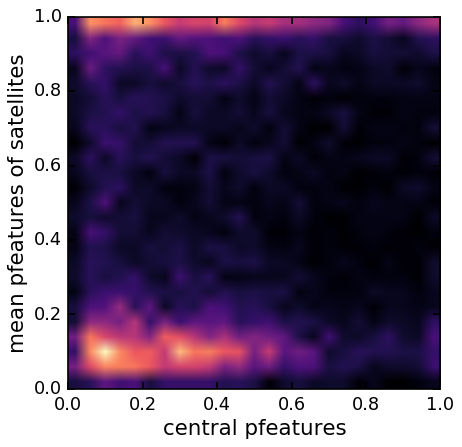

In [81]:
plt.style.use(mpl_style.style1)

hist, xedges, yedges = np.histogram2d(cent_pspiral, sat_pspiral_edit, 25)

plt.imshow(hist, extent=[np.min(cent_pspiral), np.max(cent_pspiral),np.min(sat_pspiral_edit), np.max(sat_pspiral_edit)])

#plt.scatter(cent_pspiral, sat_pspiral_edit)
plt.xlabel('central pfeatures')
plt.ylabel('mean pfeatures of satellites')
plt.show()

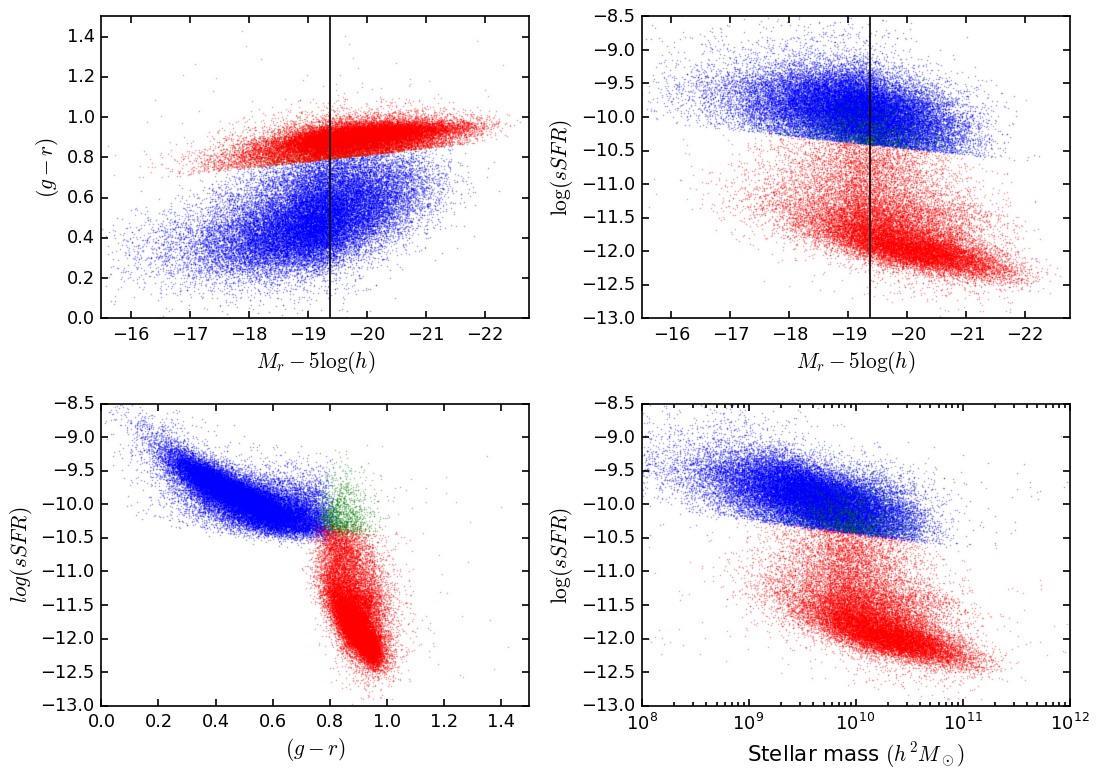

In [25]:
fig = plt.figure(figsize=(14,10))

colors = [[x[0] for x in bluact_color], [x[0] for x in redact_color], [x[0] for x in redpas_color]] #this method gets the first element of the tuples
mrs = [[x[0] for x in bluact_mr], [x[0] for x in redact_mr], [x[0] for x in redpas_mr]]
sfrs = [[x[0] for x in bluact_sfr], [x[0] for x in redact_sfr], [x[0] for x in redpas_sfr]]
masses = [[x[0] for x in bluact_mass], [x[0] for x in redact_mass], [x[0] for x in redpas_mass]]
plot_color = ['b', 'g', 'r']
plt.style.use(mpl_style.style1)
#top left plot
ax1 = fig.add_subplot(221)
for i in np.arange(3):
    ax1.scatter(mrs[i], colors[i], color = plot_color[i], s=0.1, alpha=0.5)
plt.axvline(adj_M_limit,c='k')
ax1.set_ylabel(r'$(g-r)$')
ax1.set_xlabel(r'$M_r - 5\log(h)$')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(-15.5, -22.75)

#top right plot
ax2 = fig.add_subplot(222)
for i in np.arange(3):
    ax2.scatter(mrs[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
plt.axvline(adj_M_limit,c='k')
ax2.set_ylabel(r'$\log(sSFR)$')
ax2.set_xlabel(r'$M_r - 5\log(h)$')
ax2.set_ylim(-13, -8.5)
ax2.set_xlim(-15.5, -22.75)

#bottom left plot
ax3 = fig.add_subplot(223)
for i in np.arange(3):
    ax3.scatter(colors[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
ax3.set_ylabel(r'$log(sSFR)$')
ax3.set_xlabel(r'$(g-r)$')
ax3.set_ylim(-13, -8.5)
ax3.set_xlim(0,1.5)

#bottom right plot
ax4 = fig.add_subplot(224)
for i in np.arange(3):
    ax4.scatter(masses[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
ax4.set_xlabel(r'Stellar mass $(h^2 M_\odot)$')
ax4.set_ylabel(r'$\log(sSFR)$')
ax4.set_ylim(-13, -8.5)
ax4.set_xscale('log')
ax4.set_xlim(1e8, 1e12)
#ax3.set_xlim(0,1.5)

plt.tight_layout()
plt.show()

In [ ]:
plt.hist(redpas_pfeatures, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='red and passive')
plt.hist(bluact_pfeatures, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='blue and active')
plt.hist(redact_pfeatures, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='red and active')
plt.xlabel('Pfeatures')
plt.ylabel('Frequency')
plt.title('Histogram of Pfeatures')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.hist(redpas_psmooth, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='red and passive')
plt.hist(bluact_psmooth, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='blue and active')
plt.hist(redact_psmooth, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='red and active')
plt.xlabel('psmooth')
plt.ylabel('Frequency')
plt.title('Histogram of psmooth')
plt.legend(loc='upper center')
plt.show()